In [1]:
import torch.nn as nn
from transformers import BertModel

# Bert

class BertClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        # 定义BERT模型
        self.bert = BertModel(config=bert_config)
        # 定义Dropout层
        self.dropout = nn.Dropout(p=0.2)  # Dropout概率为0.2
        # 定义分类器
        self.classifier = nn.Linear(bert_config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # BERT的输出
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # 取[CLS]位置的pooled output
        pooled = bert_output[1]
        # 在pooled output上应用Dropout
        pooled = self.dropout(pooled)
        # 分类
        logits = self.classifier(pooled)
        # 返回结果
        return logits


# Bert+BiLSTM，用法与BertClassifier一样，可直接在train里面调用
class BertLstmClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        self.bert = BertModel(config=bert_config)
        self.lstm = nn.LSTM(input_size=bert_config.hidden_size, hidden_size=bert_config.hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(bert_config.hidden_size*2, num_labels)  # 双向LSTM 需要乘以2

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = outputs.last_hidden_state
        out, _ = self.lstm(last_hidden_state)
        logits = self.classifier(out[:, -1, :]) # 取最后时刻的输出
        return logits


In [2]:
import json

# 假设你的 JSON 数据存储在一个文件中
input_file = 'data/2016.json'  # 替换为你的 JSON 文件路径
output_train_file = 'data/train.json'
output_test_file = 'data/test.json'

# 读取 JSON 数据
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 确保数据是一个列表
if isinstance(data, list):
    # 划分数据集
    train_data = data[:3109]
    test_data = data[3109:]

    # 保存训练集和测试集到文件
    with open(output_train_file, 'w', encoding='utf-8') as f_train:
        json.dump(train_data, f_train, ensure_ascii=False, indent=4)

    with open(output_test_file, 'w', encoding='utf-8') as f_test:
        json.dump(test_data, f_test, ensure_ascii=False, indent=4)

    print(f"数据集划分完成：\n训练集保存在 {output_train_file}\n测试集保存在 {output_test_file}")
else:
    print("JSON 数据不是列表格式，无法划分数据集。")

数据集划分完成：
训练集保存在 data/train.json
测试集保存在 data/test.json


In [3]:
import json
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset
import torch

class SinaNewsDataset(Dataset):
    def __init__(self,filename,tokenizer):
        
        self.labels = ["moved","angry","funny","sad","novel","shocked"]
        self.labels_id  = list(range(len(self.labels)))
        self.tokenizer = tokenizer
        self.input_ids = []
        self.token_type_ids = []
        self.attention_mask = []
        self.label_id = []
        self.label_scores = []
        self.load_data(filename)
        
    def load_data(self,filename):
        print('loading data from:', filename)
        with open(filename,'r',encoding='utf-8') as f:
            data = json.load(f)
        for item in tqdm(data):
            emotions = {k: v for k, v in item.items() if k in self.labels}
            label = max(emotions, key=emotions.get)
            text = item['news']
            label_id = self.labels.index(label)
            token = self.tokenizer(text, add_special_tokens=True, padding='max_length', truncation=True, max_length=512)
            self.input_ids.append(np.array(token['input_ids']))
            self.token_type_ids.append(np.array(token['token_type_ids']))
            self.attention_mask.append(np.array(token['attention_mask']))
            self.label_id.append(label_id)
            
            ## 添加的部分
            total = int(item["Total"])
            if total > 0:
                scores =torch.tensor([emotions[label] for label in self.labels], dtype=torch.float32)
                # label_vector = torch.softmax(scores,dim=0)  # 使用 softmax 归一化 
                label_vector = (scores / scores.sum())
            else:
                label_vector = [0.0] * len(self.labels)  # 如果 Total 为 0，所有情感归为 0
            self.label_scores.append(label_vector)
            
    def __getitem__(self, index):
        return self.input_ids[index], self.token_type_ids[index], self.attention_mask[index], self.label_id[index],self.label_scores[index],

    def __len__(self):
        return len(self.input_ids)
    
from transformers import BertTokenizer
   
def test_sina_news_dataset():
    # 创建一个测试数据文件
    test_data = [
        {
            "news": "這是一篇簡單的文章",
            "moved": 3,
            "angry": 2,
            "funny": 1,
            "sad": 0,
            "novel": 0,
            "shocked": 0,
            "Total": 6
        }
    ]

    test_filename = 'test_data.json'
    with open(test_filename, 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent=4)


    # 使用 BertTokenizer
    tokenizer = BertTokenizer.from_pretrained('model/bert-base-chinese')

    # 加载数据集
    dataset = SinaNewsDataset(test_filename, tokenizer)

    # 打印第一行
    first_item = dataset[0]
    print("Input IDs:", first_item[0])
    print("Token Type IDs:", first_item[1])
    print("Attention Mask:", first_item[2])
    print("Label ID:", first_item[3])
    print("Label Scores:", first_item[4])

# 调用测试函数
test_sina_news_dataset()

loading data from: test_data.json


100%|██████████| 1/1 [00:00<00:00, 435.59it/s]

Input IDs: [ 101 6857 3221  671 5063 5080 1606 4638 3152 4995  102    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [4]:
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertConfig
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn import metrics
from scipy.stats import pearsonr
from torch.optim import AdamW

def calculate_acc1(pred_labels, labels_score):
    """
    计算 ACC@1
    :param pred_labels: 模型预测的标签 (Tensor)
    :param labels_score: 真实标签的分数 (Tensor 或列表)
    :return: 当前 batch 的 ACC@1
    """
    correct = 0  # 正确计数
    batch_size = len(pred_labels)  # 批次大小
    label_id_rank = torch.argsort(labels_score, dim=1, descending=True)  # 对情感进行排序
    for i in range(batch_size):
        pred_label = pred_labels[i].item()
        true_rank = label_id_rank[i]
        scores = labels_score[i]

        # 判断预测是否正确
        for rank_idx in range(len(true_rank)):
            if scores[true_rank[rank_idx]] == scores[true_rank[0]]:  # 判断是否与第一分数相同
                if pred_label == true_rank[rank_idx]:  # 检查预测是否在相同分数的排名中
                    correct += 1
                    break  # 预测正确，跳出循环
            else:
                break  # 一旦分数不同，结束判断

    return correct / batch_size  # 返回准确率
def train(learning_rate = 5e-6):
    MODEL_PATH = 'model/bert-base-chinese'
    DATA_PATH = 'data/'
    batch_size = 16
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    epochs = 20
        # Learning Rate不宜太大
    tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

    train_dataset = SinaNewsDataset(DATA_PATH + 'train.json', tokenizer)
    valid_dataset = SinaNewsDataset(DATA_PATH + 'test.json', tokenizer)

    bert_config = BertConfig.from_pretrained(MODEL_PATH)
    num_labels = len(train_dataset.labels)

    model = BertClassifier(bert_config, num_labels).to(device)
    model = nn.DataParallel(model)
    optimizer = AdamW(model.parameters(), lr=learning_rate,)
    criterion = nn.CrossEntropyLoss()

    best_f1 = 0

    metrics_history = {
        'train_accuracy': [],
        'train_pearson': [],
        'valid_accuracy': [],
        'valid_pearson': []
    }

    for epoch in range(epochs):
        model.train()

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_bar = tqdm(train_dataloader, ncols=100)
        
        train_losses, train_acc,train_pearson,pearson_count  = 0, 0, 0,0

        for input_ids, token_type_ids, attention_mask, label_id ,labels_score in train_bar:
            model.zero_grad()
            train_bar.set_description(f'Epoch {epoch} train')

            output = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                token_type_ids=token_type_ids.to(device),
            )

            loss = criterion(output, label_id.to(device))
            train_losses += loss.item()
            
            pred_labels = torch.argmax(output, dim=1)
            acc = calculate_acc1(pred_labels, labels_score)
            train_acc += acc
            logits = output.clone().detach()
            
            for i in range(logits.size(0)):
                pearson, _ = pearsonr(logits[i].cpu().numpy(), labels_score[i].cpu().detach().numpy())
                train_pearson += pearson
                pearson_count += 1
                
            
            loss.backward()
            optimizer.step()
            train_bar.set_postfix(loss=loss.item(), acc=acc)
            
        train_pearson = train_pearson / pearson_count
        train_accuracy = train_acc / len(train_dataloader)
        metrics_history['train_accuracy'].append(train_accuracy)
        metrics_history['train_pearson'].append(train_pearson)
        print(f'\tTrain ACC: {train_accuracy}, Train Pearson: {train_pearson}')





        # Validation
        model.eval()
        
        valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        valid_bar = tqdm(valid_dataloader, ncols=100)
        
        valid_losses, valid_acc,valid_pearson, pearson_count,valid_preds, valid_labels = 0, 0,0,0, [], []

        for input_ids, token_type_ids, attention_mask, label_id,labels_score in valid_bar:
            valid_bar.set_description(f'Epoch {epoch} valid')

            with torch.no_grad():
                output = model(
                    input_ids=input_ids.to(device),
                    attention_mask=attention_mask.to(device),
                    token_type_ids=token_type_ids.to(device),
                )

            loss = criterion(output, label_id.to(device))
            valid_losses += loss.item()

            pred_label = torch.argmax(output, dim=1)
            # acc = torch.sum(pred_label == label_id.to(device)).item() / len(pred_label)
            acc = calculate_acc1(pred_label, labels_score)
            valid_acc += acc
            logits = output.clone()
            for i in range(logits.size(0)):
                    pearson, _ = pearsonr(logits[i].cpu().numpy(), labels_score[i].cpu().numpy())
                    valid_pearson += pearson
                    pearson_count += 1

            valid_preds.extend(pred_label.cpu().numpy())
            valid_labels.extend(label_id.cpu().numpy())
            valid_bar.set_postfix(loss=loss.item(), acc=acc)

        
        valid_pearson = valid_pearson / pearson_count
        valid_accuracy = valid_acc / len(valid_dataloader)
        metrics_history['valid_accuracy'].append(valid_accuracy)
        metrics_history['valid_pearson'].append(valid_pearson)
        print(f'\tValid ACC: {valid_accuracy}, Valid Pearson: {valid_pearson}')

        report = metrics.classification_report(valid_labels, valid_preds, labels=valid_dataset.labels_id, target_names=valid_dataset.labels)
        print('* Classification Report:')
        print(report)

        f1 = metrics.f1_score(valid_labels, valid_preds, labels=valid_dataset.labels_id, average='micro')

        if not os.path.exists('models'):
            os.makedirs('models')

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'model/best_model.pkl')

    return metrics_history

        

loading data from: data/train.json


100%|██████████| 3109/3109 [00:09<00:00, 340.00it/s]


loading data from: data/test.json


Epoch 0 train: 100%|██████████████████████████| 195/195 [01:03<00:00,  3.07it/s, acc=0.8, loss=1.17]


	Train ACC: 0.3246153846153846, Train Pearson: 0.32790862089989836


Epoch 0 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3504342410494019
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 1 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.4, loss=1.35]


	Train ACC: 0.3446794871794872, Train Pearson: 0.3342864343815944


Epoch 1 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.51it/s, acc=0, loss=1.83]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.35738179163762374
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 2 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.4, loss=1.19]


	Train ACC: 0.341474358974359, Train Pearson: 0.3352621548201756


Epoch 2 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0, loss=1.92]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38472222222222224, Valid Pearson: 0.352346166717276
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      0.99      0.56       837
       funny       0.20      0.01      0.01       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.10      0.17      0.10      2148
weighted avg       0.20      0.39      0.22      2148



Epoch 3 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=1.29]


	Train ACC: 0.3367307692307692, Train Pearson: 0.33381401994447085


Epoch 3 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0, loss=1.83]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3537026800562251
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 4 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=1.63]


	Train ACC: 0.3368589743589744, Train Pearson: 0.33171296839119924


Epoch 4 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.75it/s, acc=0, loss=1.88]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3563891811808943
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 5 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=1.09]


	Train ACC: 0.34410256410256407, Train Pearson: 0.3321418794043716


Epoch 5 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.46it/s, acc=0, loss=1.87]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3618092147323314
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 6 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=1.29]


	Train ACC: 0.3533974358974359, Train Pearson: 0.3374448396106139


Epoch 6 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.47it/s, acc=0.25, loss=1.77]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.39537037037037037, Valid Pearson: 0.3457979216630721
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.40      0.98      0.56       837
       funny       0.43      0.05      0.10       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.14      0.17      0.11      2148
weighted avg       0.26      0.40      0.24      2148



Epoch 7 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=1.35]


	Train ACC: 0.3439102564102564, Train Pearson: 0.3344941366124212


Epoch 7 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.74it/s, acc=0, loss=1.78]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38796296296296295, Valid Pearson: 0.3555288173155967
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       1.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.23      0.17      0.09      2148
weighted avg       0.40      0.39      0.22      2148



Epoch 8 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.6, loss=1.38]


	Train ACC: 0.3556410256410256, Train Pearson: 0.3363287670673559


Epoch 8 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0, loss=1.85]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3578124538305105
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 9 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.65]


	Train ACC: 0.3510897435897436, Train Pearson: 0.33602877265774056


Epoch 9 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.46it/s, acc=0, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38796296296296295, Valid Pearson: 0.3537664938714317
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       1.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.23      0.17      0.09      2148
weighted avg       0.40      0.39      0.22      2148



Epoch 10 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.52]


	Train ACC: 0.35102564102564104, Train Pearson: 0.33605194098822705


Epoch 10 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.46it/s, acc=0.25, loss=1.86]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.42268518518518516, Valid Pearson: 0.3615690577862958
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.44      0.81      0.57       837
       funny       0.39      0.44      0.41       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.42      2148
   macro avg       0.14      0.21      0.16      2148
weighted avg       0.27      0.42      0.32      2148



Epoch 11 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.51]


	Train ACC: 0.3587179487179487, Train Pearson: 0.3413632371441837


Epoch 11 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.25, loss=1.72]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4222222222222222, Valid Pearson: 0.3437933713321061
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.43      0.85      0.57       837
       funny       0.40      0.37      0.39       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.42      2148
   macro avg       0.14      0.20      0.16      2148
weighted avg       0.27      0.42      0.32      2148



Epoch 12 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.8, loss=1.28]


	Train ACC: 0.35858974358974355, Train Pearson: 0.3361077305081581


Epoch 12 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.25, loss=1.91]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3921296296296296, Valid Pearson: 0.36486587134198334
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.45      0.02      0.03       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.14      0.17      0.10      2148
weighted avg       0.26      0.39      0.23      2148



Epoch 13 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=1.9]


	Train ACC: 0.35, Train Pearson: 0.34019609059453537


Epoch 13 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.46it/s, acc=0, loss=1.85]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3888888888888889, Valid Pearson: 0.36030768173584626
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.42      0.01      0.02       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.13      0.17      0.10      2148
weighted avg       0.26      0.39      0.22      2148



Epoch 14 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.82]


	Train ACC: 0.3641666666666667, Train Pearson: 0.34009192297032176


Epoch 14 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.45it/s, acc=0.25, loss=1.82]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3912037037037037, Valid Pearson: 0.35853739498719434
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.54      0.50      0.52       837
       funny       0.31      0.79      0.44       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.14      0.22      0.16      2148
weighted avg       0.28      0.39      0.31      2148



Epoch 15 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.45]


	Train ACC: 0.3584615384615385, Train Pearson: 0.3385359344137903


Epoch 15 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.75it/s, acc=0.25, loss=1.86]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.42592592592592593, Valid Pearson: 0.3673950187018684
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.43      0.86      0.57       837
       funny       0.41      0.38      0.39       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.43      2148
   macro avg       0.14      0.21      0.16      2148
weighted avg       0.27      0.43      0.32      2148



Epoch 16 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.6, loss=1.48]


	Train ACC: 0.36076923076923073, Train Pearson: 0.34578116014881854


Epoch 16 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.71it/s, acc=0.25, loss=1.75]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.40879629629629627, Valid Pearson: 0.3598970242799681
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.40      0.97      0.57       837
       funny       0.49      0.13      0.20       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.41      2148
   macro avg       0.15      0.18      0.13      2148
weighted avg       0.28      0.41      0.27      2148



Epoch 17 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.4, loss=1.22]


	Train ACC: 0.37801282051282054, Train Pearson: 0.34581611134478407


Epoch 17 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.25, loss=1.73]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3958333333333333, Valid Pearson: 0.3617756390110728
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.53      0.04      0.07       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.15      0.17      0.11      2148
weighted avg       0.28      0.40      0.24      2148



Epoch 18 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.2, loss=1.54]


	Train ACC: 0.38083333333333336, Train Pearson: 0.34479788561223157


Epoch 18 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.45it/s, acc=0.25, loss=1.82]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.41064814814814815, Valid Pearson: 0.3651237941376713
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.47      0.68      0.56       837
       funny       0.33      0.60      0.43       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.41      2148
   macro avg       0.13      0.21      0.16      2148
weighted avg       0.27      0.41      0.32      2148



Epoch 19 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.55]


	Train ACC: 0.3825, Train Pearson: 0.3475048242353969


Epoch 19 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.75it/s, acc=0.25, loss=1.79]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3972222222222222, Valid Pearson: 0.3718426021744815
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.40      0.99      0.57       837
       funny       0.53      0.05      0.08       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.15      0.17      0.11      2148
weighted avg       0.29      0.40      0.24      2148

loading data from: data/train.json


100%|██████████| 3109/3109 [00:09<00:00, 333.06it/s]


loading data from: data/test.json


Epoch 0 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.2, loss=1.35]


	Train ACC: 0.3398076923076923, Train Pearson: 0.331189630341132


Epoch 0 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.78it/s, acc=0, loss=1.86]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3577633076004665
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 1 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.52]


	Train ACC: 0.3362820512820513, Train Pearson: 0.33131104548339935


Epoch 1 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.36it/s, acc=0.25, loss=1.78]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.25046296296296294, Valid Pearson: 0.3433046854273895
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.50      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.12      0.17      0.07      2148
weighted avg       0.26      0.25      0.10      2148



Epoch 2 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.2, loss=1.25]


	Train ACC: 0.3487820512820513, Train Pearson: 0.3332331049980333


Epoch 2 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.45it/s, acc=0, loss=1.86]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3553068453383711
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 3 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.4, loss=1.53]


	Train ACC: 0.3494871794871795, Train Pearson: 0.33261242028503674


Epoch 3 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0, loss=1.82]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3624598259484933
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 4 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.64]


	Train ACC: 0.33051282051282055, Train Pearson: 0.33581961340693184


Epoch 4 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.74it/s, acc=0, loss=1.86]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3539513237312833
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 5 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0, loss=1.49]


	Train ACC: 0.358974358974359, Train Pearson: 0.336485760338041


Epoch 5 valid: 100%|██████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.25, loss=1.8]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.34703104819439073
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 6 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=1.78]


	Train ACC: 0.35, Train Pearson: 0.33255714347910337


Epoch 6 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.45it/s, acc=0, loss=1.73]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38842592592592595, Valid Pearson: 0.3534423692326832
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       1.00      0.00      0.01       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.23      0.17      0.09      2148
weighted avg       0.40      0.39      0.22      2148



Epoch 7 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=1.18]


	Train ACC: 0.34570512820512816, Train Pearson: 0.33804117031038694


Epoch 7 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.67it/s, acc=0, loss=1.85]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38935185185185184, Valid Pearson: 0.36952637087320483
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.80      0.01      0.01       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.20      0.17      0.10      2148
weighted avg       0.35      0.39      0.22      2148



Epoch 8 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.4, loss=1.64]


	Train ACC: 0.36455128205128207, Train Pearson: 0.33964968979668586


Epoch 8 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38981481481481484, Valid Pearson: 0.3674329924044669
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.62      0.01      0.02       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.17      0.17      0.10      2148
weighted avg       0.31      0.39      0.22      2148



Epoch 9 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.2, loss=1.67]


	Train ACC: 0.36192307692307696, Train Pearson: 0.338920730556343


Epoch 9 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.40it/s, acc=0.25, loss=1.77]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.39814814814814814, Valid Pearson: 0.37124539581136
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.40      0.99      0.57       837
       funny       0.53      0.05      0.10       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.15      0.17      0.11      2148
weighted avg       0.28      0.40      0.24      2148



Epoch 10 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.4, loss=1.22]


	Train ACC: 0.36423076923076925, Train Pearson: 0.3472557093101026


Epoch 10 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.25, loss=1.76]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4013888888888889, Valid Pearson: 0.37041229934494135
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.40      0.98      0.57       837
       funny       0.49      0.08      0.14       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.15      0.18      0.12      2148
weighted avg       0.28      0.40      0.26      2148



Epoch 11 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.57]


	Train ACC: 0.3830769230769231, Train Pearson: 0.34940335925296906


Epoch 11 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.73it/s, acc=0.25, loss=1.61]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.325, Valid Pearson: 0.3575123283348524
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.62      0.25      0.36       837
       funny       0.27      0.91      0.41       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.32      2148
   macro avg       0.15      0.19      0.13      2148
weighted avg       0.31      0.32      0.24      2148



Epoch 12 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.6, loss=1.57]


	Train ACC: 0.3989102564102564, Train Pearson: 0.3539586615260003


Epoch 12 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.72it/s, acc=0.25, loss=1.83]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4060185185185185, Valid Pearson: 0.3864398111216371
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.41      0.95      0.57       837
       funny       0.42      0.15      0.22       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.41      2148
   macro avg       0.14      0.18      0.13      2148
weighted avg       0.26      0.41      0.28      2148



Epoch 13 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=1.56]


	Train ACC: 0.41365384615384615, Train Pearson: 0.3690155370618846


Epoch 13 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0.25, loss=1.64]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4027777777777778, Valid Pearson: 0.3908708131034549
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.40      0.98      0.57       837
       funny       0.52      0.09      0.15       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.15      0.18      0.12      2148
weighted avg       0.28      0.40      0.26      2148



Epoch 14 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.68]


	Train ACC: 0.431474358974359, Train Pearson: 0.38169473049052455


Epoch 14 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.25, loss=1.59]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4217592592592593, Valid Pearson: 0.3916276508011768
* Classification Report:
              precision    recall  f1-score   support

       moved       0.50      0.11      0.18       365
       angry       0.50      0.63      0.56       837
       funny       0.33      0.65      0.44       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.42      2148
   macro avg       0.22      0.23      0.20      2148
weighted avg       0.36      0.42      0.36      2148



Epoch 15 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=1.24]


	Train ACC: 0.4473076923076923, Train Pearson: 0.40474534358645675


Epoch 15 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.71it/s, acc=0.5, loss=1.34]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4810185185185185, Valid Pearson: 0.4255986981812584
* Classification Report:
              precision    recall  f1-score   support

       moved       0.53      0.39      0.45       365
       angry       0.48      0.84      0.61       837
       funny       0.46      0.36      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.48      2148
   macro avg       0.24      0.26      0.24      2148
weighted avg       0.39      0.48      0.41      2148



Epoch 16 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.2, loss=1.72]


	Train ACC: 0.4644871794871795, Train Pearson: 0.4256343580724345


Epoch 16 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0.5, loss=1.37]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4759259259259259, Valid Pearson: 0.45235118492513876
* Classification Report:
              precision    recall  f1-score   support

       moved       0.57      0.35      0.43       365
       angry       0.51      0.72      0.60       837
       funny       0.40      0.54      0.46       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.47      2148
   macro avg       0.25      0.27      0.25      2148
weighted avg       0.39      0.47      0.42      2148



Epoch 17 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.4, loss=1.31]


	Train ACC: 0.4956410256410257, Train Pearson: 0.45373401999524793


Epoch 17 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.41it/s, acc=0.5, loss=1.34]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5013888888888889, Valid Pearson: 0.48135798388397594
* Classification Report:
              precision    recall  f1-score   support

       moved       0.53      0.45      0.49       365
       angry       0.51      0.78      0.62       837
       funny       0.46      0.48      0.47       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.50      2148
   macro avg       0.25      0.29      0.26      2148
weighted avg       0.40      0.50      0.44      2148



Epoch 18 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=1.16]


	Train ACC: 0.5110897435897436, Train Pearson: 0.46950603914041406


Epoch 18 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.37it/s, acc=0.5, loss=1.31]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.46296296296296297, Valid Pearson: 0.4778231940193481
* Classification Report:
              precision    recall  f1-score   support

       moved       0.52      0.45      0.49       365
       angry       0.59      0.48      0.53       837
       funny       0.37      0.80      0.51       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.46      2148
   macro avg       0.25      0.29      0.25      2148
weighted avg       0.41      0.46      0.41      2148



Epoch 19 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=1, loss=0.577]


	Train ACC: 0.5240384615384616, Train Pearson: 0.49042449970204005


Epoch 19 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.69it/s, acc=0.25, loss=1.29]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.49074074074074076, Valid Pearson: 0.5053876353531361
* Classification Report:
              precision    recall  f1-score   support

       moved       0.63      0.28      0.39       365
       angry       0.51      0.74      0.61       837
       funny       0.43      0.62      0.50       530
         sad       0.75      0.01      0.02       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.49      2148
   macro avg       0.39      0.28      0.25      2148
weighted avg       0.51      0.49      0.43      2148

loading data from: data/train.json


100%|██████████| 3109/3109 [00:09<00:00, 341.15it/s]


loading data from: data/test.json


Epoch 0 train: 100%|███████████████████████████| 195/195 [01:06<00:00,  2.93it/s, acc=0.2, loss=1.5]


	Train ACC: 0.3346794871794872, Train Pearson: 0.32672326923071215


Epoch 0 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.79it/s, acc=0.25, loss=1.75]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3450298109762033
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 1 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.6, loss=1.05]


	Train ACC: 0.3325641025641025, Train Pearson: 0.3322906585410876


Epoch 1 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.41it/s, acc=0.25, loss=1.84]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.40324074074074073, Valid Pearson: 0.3470058531118147
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.40      0.96      0.57       837
       funny       0.42      0.12      0.19       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.14      0.18      0.13      2148
weighted avg       0.26      0.40      0.27      2148



Epoch 2 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.5]


	Train ACC: 0.34365384615384614, Train Pearson: 0.333784805319728


Epoch 2 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.48it/s, acc=0, loss=1.89]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3568698645952777
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 3 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.45]


	Train ACC: 0.33442307692307693, Train Pearson: 0.3316178820970854


Epoch 3 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0, loss=1.63]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38842592592592595, Valid Pearson: 0.33734928661012
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.67      0.00      0.01       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.18      0.17      0.09      2148
weighted avg       0.32      0.39      0.22      2148



Epoch 4 train: 100%|███████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.2, loss=1.4]


	Train ACC: 0.35583333333333333, Train Pearson: 0.3301802962113617


Epoch 4 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.73it/s, acc=0.25, loss=1.71]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.39351851851851855, Valid Pearson: 0.35670672210990756
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.59      0.02      0.05       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.16      0.17      0.10      2148
weighted avg       0.30      0.39      0.23      2148



Epoch 5 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=1.14]


	Train ACC: 0.3533974358974359, Train Pearson: 0.3386935373988295


Epoch 5 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0.25, loss=1.87]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3958333333333333, Valid Pearson: 0.35934075712099317
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.56      0.04      0.07       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.16      0.17      0.11      2148
weighted avg       0.29      0.40      0.24      2148



Epoch 6 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=1.56]


	Train ACC: 0.36878205128205127, Train Pearson: 0.339030554597222


Epoch 6 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0.25, loss=1.79]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.2513888888888889, Valid Pearson: 0.35693845870283747
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.80      0.00      0.01       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.17      0.17      0.07      2148
weighted avg       0.37      0.25      0.10      2148



Epoch 7 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.29]


	Train ACC: 0.3680769230769231, Train Pearson: 0.3432849780790037


Epoch 7 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.74it/s, acc=0.25, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38657407407407407, Valid Pearson: 0.38671919090970147
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.54      0.59      0.56       837
       funny       0.27      0.64      0.38       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.14      0.20      0.16      2148
weighted avg       0.28      0.39      0.31      2148



Epoch 8 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.4, loss=1.41]


	Train ACC: 0.3930769230769231, Train Pearson: 0.37003671654789844


Epoch 8 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.25, loss=1.52]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.29305555555555557, Valid Pearson: 0.37268362986813464
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.79      0.13      0.23       837
       funny       0.26      0.97      0.41       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.29      2148
   macro avg       0.17      0.18      0.11      2148
weighted avg       0.37      0.29      0.19      2148



Epoch 9 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=1.9]


	Train ACC: 0.4337179487179487, Train Pearson: 0.4016143941751496


Epoch 9 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.47it/s, acc=0.25, loss=1.78]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4009259259259259, Valid Pearson: 0.44666183921598324
* Classification Report:
              precision    recall  f1-score   support

       moved       0.43      0.02      0.03       365
       angry       0.55      0.63      0.59       837
       funny       0.28      0.62      0.39       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.21      0.21      0.17      2148
weighted avg       0.36      0.40      0.33      2148



Epoch 10 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.4, loss=1.51]


	Train ACC: 0.47000000000000003, Train Pearson: 0.4439973532291864


Epoch 10 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.48it/s, acc=0.5, loss=1.53]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4847222222222222, Valid Pearson: 0.4915827095051227
* Classification Report:
              precision    recall  f1-score   support

       moved       0.48      0.48      0.48       365
       angry       0.53      0.76      0.62       837
       funny       0.40      0.44      0.42       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.48      2148
   macro avg       0.23      0.28      0.25      2148
weighted avg       0.38      0.48      0.43      2148



Epoch 11 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.4, loss=1.33]


	Train ACC: 0.5030128205128206, Train Pearson: 0.48732545672017225


Epoch 11 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.72it/s, acc=0.5, loss=1.21]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5222222222222223, Valid Pearson: 0.5016051142259966
* Classification Report:
              precision    recall  f1-score   support

       moved       0.48      0.54      0.51       365
       angry       0.55      0.78      0.64       837
       funny       0.48      0.39      0.43       530
         sad       0.56      0.21      0.30       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.52      2148
   macro avg       0.35      0.32      0.31      2148
weighted avg       0.49      0.52      0.49      2148



Epoch 12 train: 100%|████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.6, loss=0.681]


	Train ACC: 0.5235897435897435, Train Pearson: 0.5022302664679174


Epoch 12 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.75it/s, acc=0.75, loss=1.05]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5069444444444444, Valid Pearson: 0.5098388708883362
* Classification Report:
              precision    recall  f1-score   support

       moved       0.50      0.51      0.50       365
       angry       0.66      0.47      0.55       837
       funny       0.42      0.71      0.52       530
         sad       0.46      0.43      0.45       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.50      2148
   macro avg       0.34      0.35      0.34      2148
weighted avg       0.51      0.50      0.49      2148



Epoch 13 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=1, loss=0.472]


	Train ACC: 0.5573717948717949, Train Pearson: 0.5383795344945626


Epoch 13 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.47it/s, acc=0.25, loss=1.1]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5175925925925926, Valid Pearson: 0.5345600150918349
* Classification Report:
              precision    recall  f1-score   support

       moved       0.49      0.51      0.50       365
       angry       0.63      0.57      0.60       837
       funny       0.43      0.64      0.51       530
         sad       0.53      0.38      0.44       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.52      2148
   macro avg       0.34      0.35      0.34      2148
weighted avg       0.50      0.52      0.50      2148



Epoch 14 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=1.42]


	Train ACC: 0.5607692307692307, Train Pearson: 0.5406348750974497


Epoch 14 valid: 100%|██████████████████████████| 135/135 [00:18<00:00,  7.48it/s, acc=1, loss=0.898]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5537037037037037, Valid Pearson: 0.5293559547564213
* Classification Report:
              precision    recall  f1-score   support

       moved       0.49      0.57      0.53       365
       angry       0.62      0.70      0.66       837
       funny       0.53      0.47      0.50       530
         sad       0.44      0.47      0.46       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.55      2148
   macro avg       0.35      0.37      0.36      2148
weighted avg       0.52      0.55      0.53      2148



Epoch 15 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=2.11]


	Train ACC: 0.5833333333333334, Train Pearson: 0.5617488407554165


Epoch 15 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.74it/s, acc=0.5, loss=0.99]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5115740740740741, Valid Pearson: 0.47607759649647347
* Classification Report:
              precision    recall  f1-score   support

       moved       0.40      0.72      0.51       365
       angry       0.58      0.76      0.66       837
       funny       0.73      0.14      0.23       530
         sad       0.44      0.43      0.44       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.51      2148
   macro avg       0.36      0.34      0.31      2148
weighted avg       0.53      0.51      0.46      2148



Epoch 16 train: 100%|████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.4, loss=0.758]


	Train ACC: 0.5853846153846154, Train Pearson: 0.5688443185376791


Epoch 16 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.25, loss=1.31]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5342592592592592, Valid Pearson: 0.561891370540174
* Classification Report:
              precision    recall  f1-score   support

       moved       0.53      0.46      0.50       365
       angry       0.59      0.69      0.63       837
       funny       0.46      0.64      0.54       530
         sad       0.57      0.22      0.31       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.53      2148
   macro avg       0.36      0.33      0.33      2148
weighted avg       0.51      0.53      0.51      2148



Epoch 17 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.7]


	Train ACC: 0.5894871794871795, Train Pearson: 0.5757013604824263


Epoch 17 valid: 100%|███████████████████████| 135/135 [00:18<00:00,  7.40it/s, acc=0.75, loss=0.973]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5648148148148148, Valid Pearson: 0.5554997829869042
* Classification Report:
              precision    recall  f1-score   support

       moved       0.51      0.53      0.52       365
       angry       0.60      0.75      0.67       837
       funny       0.53      0.51      0.52       530
         sad       0.55      0.40      0.46       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.56      2148
   macro avg       0.36      0.36      0.36      2148
weighted avg       0.53      0.56      0.54      2148



Epoch 18 train: 100%|████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=0.798]


	Train ACC: 0.6011538461538461, Train Pearson: 0.5781048669152051


Epoch 18 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.47it/s, acc=0.25, loss=1.35]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5328703703703703, Valid Pearson: 0.5623975225781083
* Classification Report:
              precision    recall  f1-score   support

       moved       0.47      0.59      0.52       365
       angry       0.63      0.63      0.63       837
       funny       0.46      0.68      0.55       530
         sad       0.61      0.14      0.23       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.53      2148
   macro avg       0.36      0.34      0.32      2148
weighted avg       0.52      0.53      0.50      2148



Epoch 19 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.6, loss=1.1]


	Train ACC: 0.6245512820512821, Train Pearson: 0.5948740602534909


Epoch 19 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.77it/s, acc=0.5, loss=1.02]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5638888888888889, Valid Pearson: 0.5631648384124103
* Classification Report:
              precision    recall  f1-score   support

       moved       0.46      0.65      0.54       365
       angry       0.63      0.72      0.67       837
       funny       0.53      0.53      0.53       530
         sad       0.61      0.30      0.40       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.56      2148
   macro avg       0.37      0.37      0.36      2148
weighted avg       0.54      0.56      0.54      2148

loading data from: data/train.json


100%|██████████| 3109/3109 [00:09<00:00, 341.12it/s]


loading data from: data/test.json


Epoch 0 train: 100%|████████████████████████████| 195/195 [01:05<00:00,  2.95it/s, acc=0, loss=1.55]


	Train ACC: 0.33621794871794874, Train Pearson: 0.32364148160272493


Epoch 0 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.77it/s, acc=0, loss=1.86]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.350306309608197
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 1 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.4, loss=1.59]


	Train ACC: 0.3475641025641026, Train Pearson: 0.3291602066147937


Epoch 1 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.38it/s, acc=0, loss=1.75]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3562459214284818
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 2 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=2.1]


	Train ACC: 0.3487820512820513, Train Pearson: 0.33036620913615417


Epoch 2 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0.25, loss=1.71]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.34862715628349406
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 3 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=1.76]


	Train ACC: 0.3368589743589744, Train Pearson: 0.3360650666912514


Epoch 3 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0, loss=1.71]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38842592592592595, Valid Pearson: 0.3534557844276211
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.67      0.00      0.01       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.18      0.17      0.09      2148
weighted avg       0.32      0.39      0.22      2148



Epoch 4 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.4, loss=1.71]


	Train ACC: 0.3587820512820513, Train Pearson: 0.3329936868935045


Epoch 4 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.72it/s, acc=0, loss=1.96]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.38796296296296295, Valid Pearson: 0.38552191200809816
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       1.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.23      0.17      0.09      2148
weighted avg       0.40      0.39      0.22      2148



Epoch 5 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.6, loss=1.11]


	Train ACC: 0.41365384615384615, Train Pearson: 0.3731642788894999


Epoch 5 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.48it/s, acc=0.25, loss=1.62]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.41435185185185186, Valid Pearson: 0.4269099461889184
* Classification Report:
              precision    recall  f1-score   support

       moved       0.58      0.04      0.07       365
       angry       0.52      0.71      0.60       837
       funny       0.28      0.53      0.37       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.41      2148
   macro avg       0.23      0.21      0.17      2148
weighted avg       0.37      0.41      0.34      2148



Epoch 6 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=1.64]


	Train ACC: 0.47583333333333333, Train Pearson: 0.4351576001766562


Epoch 6 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.41it/s, acc=0.25, loss=1.72]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.40879629629629627, Valid Pearson: 0.46030171127282293
* Classification Report:
              precision    recall  f1-score   support

       moved       0.41      0.04      0.07       365
       angry       0.64      0.54      0.59       837
       funny       0.29      0.77      0.42       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.41      2148
   macro avg       0.22      0.22      0.18      2148
weighted avg       0.39      0.41      0.34      2148



Epoch 7 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=1.04]


	Train ACC: 0.5123717948717949, Train Pearson: 0.4820760478429417


Epoch 7 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.69it/s, acc=0.25, loss=1.64]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5087962962962963, Valid Pearson: 0.534130906125742
* Classification Report:
              precision    recall  f1-score   support

       moved       0.57      0.33      0.42       365
       angry       0.55      0.71      0.62       837
       funny       0.44      0.66      0.53       530
         sad       0.47      0.10      0.17       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.51      2148
   macro avg       0.34      0.30      0.29      2148
weighted avg       0.48      0.51      0.47      2148



Epoch 8 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.6, loss=0.88]


	Train ACC: 0.5626923076923077, Train Pearson: 0.541164793375864


Epoch 8 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.69it/s, acc=0.25, loss=1.19]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5425925925925926, Valid Pearson: 0.5223451635963358
* Classification Report:
              precision    recall  f1-score   support

       moved       0.55      0.38      0.45       365
       angry       0.57      0.81      0.67       837
       funny       0.52      0.52      0.52       530
         sad       0.41      0.25      0.31       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.54      2148
   macro avg       0.34      0.33      0.33      2148
weighted avg       0.50      0.54      0.51      2148



Epoch 9 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.85]


	Train ACC: 0.5885897435897436, Train Pearson: 0.5630656061284275


Epoch 9 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.47it/s, acc=0.75, loss=1.14]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5657407407407408, Valid Pearson: 0.5558800185650873
* Classification Report:
              precision    recall  f1-score   support

       moved       0.52      0.57      0.54       365
       angry       0.63      0.68      0.66       837
       funny       0.51      0.62      0.56       530
         sad       0.52      0.36      0.42       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.56      2148
   macro avg       0.36      0.37      0.36      2148
weighted avg       0.53      0.56      0.54      2148



Epoch 10 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=1, loss=0.494]


	Train ACC: 0.6051282051282051, Train Pearson: 0.5841188533531745


Epoch 10 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.41it/s, acc=0.25, loss=2.13]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4486111111111111, Valid Pearson: 0.5260014231970193
* Classification Report:
              precision    recall  f1-score   support

       moved       0.55      0.20      0.29       365
       angry       0.67      0.45      0.54       837
       funny       0.34      0.91      0.50       530
         sad       0.58      0.12      0.19       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.45      2148
   macro avg       0.36      0.28      0.25      2148
weighted avg       0.52      0.45      0.41      2148



Epoch 11 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=1, loss=0.502]


	Train ACC: 0.6275641025641026, Train Pearson: 0.598685878489215


Epoch 11 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.69it/s, acc=0.25, loss=1.6]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5388888888888889, Valid Pearson: 0.5740974609876013
* Classification Report:
              precision    recall  f1-score   support

       moved       0.53      0.42      0.47       365
       angry       0.63      0.71      0.66       837
       funny       0.44      0.68      0.54       530
         sad       0.51      0.18      0.27       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.54      2148
   macro avg       0.35      0.33      0.32      2148
weighted avg       0.51      0.54      0.51      2148



Epoch 12 train: 100%|████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.4, loss=0.964]


	Train ACC: 0.6417948717948718, Train Pearson: 0.6108748502905684


Epoch 12 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.73it/s, acc=0.5, loss=1.55]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5314814814814814, Valid Pearson: 0.5749137426043914
* Classification Report:
              precision    recall  f1-score   support

       moved       0.54      0.39      0.45       365
       angry       0.66      0.61      0.63       837
       funny       0.42      0.78      0.55       530
         sad       0.54      0.25      0.34       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.53      2148
   macro avg       0.36      0.34      0.33      2148
weighted avg       0.53      0.53      0.51      2148



Epoch 13 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=0.84]


	Train ACC: 0.6607692307692308, Train Pearson: 0.6349108582343319


Epoch 13 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0.75, loss=1.06]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5578703703703703, Valid Pearson: 0.553608989422821
* Classification Report:
              precision    recall  f1-score   support

       moved       0.50      0.50      0.50       365
       angry       0.58      0.88      0.70       837
       funny       0.68      0.26      0.38       530
         sad       0.44      0.48      0.46       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.56      2148
   macro avg       0.37      0.35      0.34      2148
weighted avg       0.54      0.56      0.51      2148



Epoch 14 train: 100%|████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=0.703]


	Train ACC: 0.6915384615384615, Train Pearson: 0.644369452797381


Epoch 14 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0.25, loss=1.78]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.49907407407407406, Valid Pearson: 0.509268799674043
* Classification Report:
              precision    recall  f1-score   support

       moved       0.43      0.59      0.50       365
       angry       0.76      0.45      0.56       837
       funny       0.41      0.83      0.55       530
         sad       0.60      0.11      0.19       292
       novel       0.24      0.15      0.18        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.50      2148
   macro avg       0.41      0.35      0.33      2148
weighted avg       0.55      0.50      0.47      2148



Epoch 15 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=1.1]


	Train ACC: 0.6883333333333334, Train Pearson: 0.6519422812455975


Epoch 15 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0.25, loss=1.67]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5337962962962963, Valid Pearson: 0.5689691678873174
* Classification Report:
              precision    recall  f1-score   support

       moved       0.61      0.24      0.35       365
       angry       0.55      0.80      0.65       837
       funny       0.51      0.60      0.55       530
         sad       0.46      0.24      0.31       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.53      2148
   macro avg       0.35      0.31      0.31      2148
weighted avg       0.50      0.53      0.49      2148



Epoch 16 train: 100%|████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.8, loss=0.469]


	Train ACC: 0.6999358974358975, Train Pearson: 0.6561901742390948


Epoch 16 valid: 100%|██████████████████████████| 135/135 [00:17<00:00,  7.72it/s, acc=1, loss=0.662]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5671296296296297, Valid Pearson: 0.5849246606200809
* Classification Report:
              precision    recall  f1-score   support

       moved       0.51      0.61      0.56       365
       angry       0.71      0.59      0.65       837
       funny       0.50      0.67      0.57       530
         sad       0.45      0.46      0.45       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.56      2148
   macro avg       0.36      0.39      0.37      2148
weighted avg       0.55      0.56      0.55      2148



Epoch 17 train: 100%|████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.8, loss=0.546]


	Train ACC: 0.7300641025641026, Train Pearson: 0.680830066191309


Epoch 17 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0.75, loss=1.06]


	Valid ACC: 0.5407407407407407, Valid Pearson: 0.5732844344761191
* Classification Report:
              precision    recall  f1-score   support

       moved       0.55      0.53      0.54       365
       angry       0.74      0.50      0.60       837
       funny       0.42      0.81      0.56       530
         sad       0.54      0.38      0.45       292
       novel       0.23      0.09      0.13        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.54      2148
   macro avg       0.41      0.38      0.38      2148
weighted avg       0.56      0.54      0.52      2148



Epoch 18 train: 100%|████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.8, loss=0.564]


	Train ACC: 0.731025641025641, Train Pearson: 0.6808049337369462


Epoch 18 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0.5, loss=0.881]


	Valid ACC: 0.5634259259259259, Valid Pearson: 0.5664649046742156
* Classification Report:
              precision    recall  f1-score   support

       moved       0.50      0.67      0.57       365
       angry       0.70      0.63      0.66       837
       funny       0.50      0.60      0.55       530
         sad       0.52      0.36      0.43       292
       novel       0.15      0.32      0.20        34
     shocked       0.33      0.01      0.02        90

    accuracy                           0.56      2148
   macro avg       0.45      0.43      0.41      2148
weighted avg       0.57      0.56      0.55      2148



Epoch 19 train: 100%|████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.8, loss=0.916]


	Train ACC: 0.7560256410256411, Train Pearson: 0.6955866159512514


Epoch 19 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.71it/s, acc=0.5, loss=1.37]


	Valid ACC: 0.5638888888888889, Valid Pearson: 0.5752784239116873
* Classification Report:
              precision    recall  f1-score   support

       moved       0.56      0.45      0.50       365
       angry       0.58      0.89      0.70       837
       funny       0.67      0.27      0.39       530
         sad       0.44      0.52      0.48       292
       novel       0.00      0.00      0.00        34
     shocked       1.00      0.01      0.02        90

    accuracy                           0.56      2148
   macro avg       0.54      0.36      0.35      2148
weighted avg       0.59      0.56      0.52      2148

loading data from: data/train.json


100%|██████████| 3109/3109 [00:09<00:00, 333.17it/s]


loading data from: data/test.json


Epoch 0 train: 100%|██████████████████████████| 195/195 [01:06<00:00,  2.92it/s, acc=0.4, loss=1.38]


	Train ACC: 0.33891025641025646, Train Pearson: 0.32499058898516436


Epoch 0 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.78it/s, acc=0, loss=1.64]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3352978186189635
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 1 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=2.04]


	Train ACC: 0.34134615384615385, Train Pearson: 0.3270833965670464


Epoch 1 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.40it/s, acc=0.25, loss=1.88]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.36361965660966783
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 2 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.2, loss=1.46]


	Train ACC: 0.32121794871794873, Train Pearson: 0.32841970787347663


Epoch 2 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0.25, loss=1.72]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.33758456968364037
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 3 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.8, loss=1.08]


	Train ACC: 0.3367948717948718, Train Pearson: 0.32750114033820177


Epoch 3 valid: 100%|███████████████████████████████| 135/135 [00:17<00:00,  7.71it/s, acc=0, loss=2]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.37064339703514043
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 4 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.4, loss=1.53]


	Train ACC: 0.35012820512820514, Train Pearson: 0.34365588174868333


Epoch 4 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.71it/s, acc=0.25, loss=1.59]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.21342592592592594, Valid Pearson: 0.21404427298675838
* Classification Report:
              precision    recall  f1-score   support

       moved       0.19      0.99      0.32       365
       angry       0.71      0.03      0.05       837
       funny       0.33      0.14      0.19       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.21      2148
   macro avg       0.21      0.19      0.09      2148
weighted avg       0.39      0.21      0.12      2148



Epoch 5 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.2, loss=1.07]


	Train ACC: 0.40102564102564103, Train Pearson: 0.40134067658070555


Epoch 5 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.25, loss=1.71]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.41712962962962963, Valid Pearson: 0.43918661480352417
* Classification Report:
              precision    recall  f1-score   support

       moved       0.53      0.05      0.09       365
       angry       0.56      0.75      0.64       837
       funny       0.25      0.47      0.33       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.42      2148
   macro avg       0.22      0.21      0.18      2148
weighted avg       0.37      0.42      0.34      2148



Epoch 6 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.8, loss=0.844]


	Train ACC: 0.49256410256410255, Train Pearson: 0.47089286590751456


Epoch 6 valid: 100%|██████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.5, loss=1.43]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.48703703703703705, Valid Pearson: 0.5281466541792162
* Classification Report:
              precision    recall  f1-score   support

       moved       0.53      0.42      0.47       365
       angry       0.64      0.46      0.54       837
       funny       0.38      0.77      0.51       530
         sad       0.53      0.32      0.40       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.49      2148
   macro avg       0.35      0.33      0.32      2148
weighted avg       0.50      0.49      0.47      2148



Epoch 7 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=0.793]


	Train ACC: 0.5658974358974359, Train Pearson: 0.5510415304768457


Epoch 7 valid: 100%|██████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0.5, loss=1.16]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5717592592592593, Valid Pearson: 0.5728691362410817
* Classification Report:
              precision    recall  f1-score   support

       moved       0.54      0.58      0.56       365
       angry       0.61      0.78      0.68       837
       funny       0.56      0.48      0.51       530
         sad       0.49      0.37      0.42       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.57      2148
   macro avg       0.36      0.37      0.36      2148
weighted avg       0.53      0.57      0.55      2148



Epoch 8 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.8, loss=0.522]


	Train ACC: 0.6175641025641025, Train Pearson: 0.5829799811061668


Epoch 8 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.25, loss=1.83]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5, Valid Pearson: 0.5531121430211037
* Classification Report:
              precision    recall  f1-score   support

       moved       0.61      0.21      0.31       365
       angry       0.60      0.58      0.59       837
       funny       0.41      0.79      0.54       530
         sad       0.48      0.33      0.39       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.50      2148
   macro avg       0.35      0.32      0.30      2148
weighted avg       0.50      0.50      0.47      2148



Epoch 9 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=1.21]


	Train ACC: 0.640576923076923, Train Pearson: 0.6017434407130476


Epoch 9 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.47it/s, acc=0.25, loss=1.27]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5712962962962963, Valid Pearson: 0.5741897063717282
* Classification Report:
              precision    recall  f1-score   support

       moved       0.50      0.65      0.57       365
       angry       0.67      0.65      0.66       837
       funny       0.52      0.58      0.55       530
         sad       0.51      0.47      0.49       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.57      2148
   macro avg       0.37      0.39      0.38      2148
weighted avg       0.55      0.57      0.56      2148



Epoch 10 train: 100%|████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=0.736]


	Train ACC: 0.6687820512820513, Train Pearson: 0.6336638901885484


Epoch 10 valid: 100%|██████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0.5, loss=1.2]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5810185185185185, Valid Pearson: 0.5947244672882134
* Classification Report:
              precision    recall  f1-score   support

       moved       0.60      0.46      0.52       365
       angry       0.66      0.70      0.68       837
       funny       0.50      0.64      0.56       530
         sad       0.51      0.53      0.52       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.58      2148
   macro avg       0.38      0.39      0.38      2148
weighted avg       0.55      0.58      0.56      2148



Epoch 11 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.8, loss=1.48]


	Train ACC: 0.6861538461538462, Train Pearson: 0.6527199518459905


Epoch 11 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0.25, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5481481481481482, Valid Pearson: 0.5831697702964351
* Classification Report:
              precision    recall  f1-score   support

       moved       0.60      0.42      0.49       365
       angry       0.69      0.58      0.63       837
       funny       0.43      0.80      0.56       530
         sad       0.58      0.40      0.47       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.55      2148
   macro avg       0.38      0.37      0.36      2148
weighted avg       0.56      0.55      0.53      2148



Epoch 12 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=1, loss=0.392]


	Train ACC: 0.7237179487179487, Train Pearson: 0.6667832639740284


Epoch 12 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.25, loss=1.25]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.575925925925926, Valid Pearson: 0.5915822711115907
* Classification Report:
              precision    recall  f1-score   support

       moved       0.55      0.48      0.51       365
       angry       0.68      0.68      0.68       837
       funny       0.54      0.57      0.55       530
         sad       0.46      0.62      0.53       292
       novel       0.33      0.21      0.25        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.58      2148
   macro avg       0.43      0.43      0.42      2148
weighted avg       0.56      0.58      0.56      2148



Epoch 13 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=0.5]


	Train ACC: 0.7399358974358974, Train Pearson: 0.6874457593471668


Epoch 13 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0.25, loss=1.5]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5731481481481482, Valid Pearson: 0.5724974950336644
* Classification Report:
              precision    recall  f1-score   support

       moved       0.47      0.66      0.55       365
       angry       0.65      0.73      0.69       837
       funny       0.59      0.45      0.51       530
         sad       0.47      0.47      0.47       292
       novel       0.25      0.03      0.05        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.57      2148
   macro avg       0.41      0.39      0.38      2148
weighted avg       0.55      0.57      0.55      2148



Epoch 14 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.29]


	Train ACC: 0.7639102564102564, Train Pearson: 0.7037517333441107


Epoch 14 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0.75, loss=1.84]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5504629629629629, Valid Pearson: 0.5830312586159265
* Classification Report:
              precision    recall  f1-score   support

       moved       0.57      0.27      0.37       365
       angry       0.58      0.80      0.67       837
       funny       0.54      0.54      0.54       530
         sad       0.44      0.42      0.43       292
       novel       0.00      0.00      0.00        34
     shocked       0.17      0.01      0.02        90

    accuracy                           0.55      2148
   macro avg       0.38      0.34      0.34      2148
weighted avg       0.52      0.55      0.52      2148



Epoch 15 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=1, loss=0.117]


	Train ACC: 0.7775641025641026, Train Pearson: 0.7043745395343147


Epoch 15 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0.25, loss=2.12]


	Valid ACC: 0.5569444444444445, Valid Pearson: 0.5762366681441915
* Classification Report:
              precision    recall  f1-score   support

       moved       0.51      0.59      0.55       365
       angry       0.70      0.59      0.64       837
       funny       0.49      0.65      0.56       530
         sad       0.47      0.45      0.46       292
       novel       0.29      0.26      0.28        34
     shocked       0.33      0.01      0.02        90

    accuracy                           0.56      2148
   macro avg       0.47      0.43      0.42      2148
weighted avg       0.56      0.56      0.55      2148



Epoch 16 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.8, loss=1.53]


	Train ACC: 0.791923076923077, Train Pearson: 0.7155440208892033


Epoch 16 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.71it/s, acc=0.25, loss=2.64]


	Valid ACC: 0.5361111111111111, Valid Pearson: 0.5788249585601603
* Classification Report:
              precision    recall  f1-score   support

       moved       0.62      0.25      0.35       365
       angry       0.59      0.81      0.68       837
       funny       0.44      0.58      0.50       530
         sad       0.53      0.24      0.33       292
       novel       0.30      0.09      0.14        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.54      2148
   macro avg       0.41      0.33      0.33      2148
weighted avg       0.52      0.54      0.50      2148



Epoch 17 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=1, loss=0.273]


	Train ACC: 0.8288461538461539, Train Pearson: 0.7363669205787343


Epoch 17 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0.25, loss=2.43]


	Valid ACC: 0.562037037037037, Valid Pearson: 0.5853430652020358
* Classification Report:
              precision    recall  f1-score   support

       moved       0.57      0.46      0.51       365
       angry       0.67      0.68      0.68       837
       funny       0.52      0.58      0.55       530
         sad       0.45      0.50      0.48       292
       novel       0.42      0.29      0.34        34
     shocked       0.14      0.12      0.13        90

    accuracy                           0.56      2148
   macro avg       0.46      0.44      0.45      2148
weighted avg       0.56      0.56      0.56      2148



Epoch 18 train: 100%|████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.8, loss=0.528]


	Train ACC: 0.861474358974359, Train Pearson: 0.7647366808827231


Epoch 18 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.5, loss=2.13]


	Valid ACC: 0.5472222222222223, Valid Pearson: 0.5618839553333522
* Classification Report:
              precision    recall  f1-score   support

       moved       0.62      0.35      0.45       365
       angry       0.58      0.85      0.69       837
       funny       0.53      0.38      0.44       530
         sad       0.41      0.42      0.42       292
       novel       0.40      0.18      0.24        34
     shocked       0.20      0.04      0.07        90

    accuracy                           0.55      2148
   macro avg       0.46      0.37      0.39      2148
weighted avg       0.53      0.55      0.52      2148



Epoch 19 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=1, loss=0.138]


	Train ACC: 0.882051282051282, Train Pearson: 0.7784223302953241


Epoch 19 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.75it/s, acc=0.25, loss=2.81]


	Valid ACC: 0.5555555555555556, Valid Pearson: 0.5715232866757827
* Classification Report:
              precision    recall  f1-score   support

       moved       0.55      0.55      0.55       365
       angry       0.69      0.62      0.65       837
       funny       0.49      0.58      0.53       530
         sad       0.45      0.51      0.48       292
       novel       0.26      0.35      0.30        34
     shocked       0.17      0.02      0.04        90

    accuracy                           0.56      2148
   macro avg       0.43      0.44      0.43      2148
weighted avg       0.55      0.56      0.55      2148

loading data from: data/train.json


100%|██████████| 3109/3109 [00:09<00:00, 332.99it/s]


loading data from: data/test.json


Epoch 0 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.96it/s, acc=0.4, loss=1.25]


	Train ACC: 0.33666666666666667, Train Pearson: 0.3211485223522335


Epoch 0 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.83it/s, acc=0, loss=1.74]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3255121033614551
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 1 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0, loss=1.86]


	Train ACC: 0.33653846153846156, Train Pearson: 0.3304646951259818


Epoch 1 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.39it/s, acc=0, loss=1.91]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.36843046913464206
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 2 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=1.31]


	Train ACC: 0.34570512820512816, Train Pearson: 0.32686372474555175


Epoch 2 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.48it/s, acc=0, loss=1.68]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.32145950595646755
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 3 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0, loss=1.43]


	Train ACC: 0.3387820512820513, Train Pearson: 0.32680563085093856


Epoch 3 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.74it/s, acc=0, loss=1.78]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.33517430605615095
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 4 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.4, loss=1.23]


	Train ACC: 0.3523717948717949, Train Pearson: 0.348817677100733


Epoch 4 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.75it/s, acc=0.25, loss=2.01]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4023148148148148, Valid Pearson: 0.4194415832963567
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.51      0.83      0.63       837
       funny       0.22      0.32      0.26       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.40      2148
   macro avg       0.12      0.19      0.15      2148
weighted avg       0.25      0.40      0.31      2148



Epoch 5 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=1.84]


	Train ACC: 0.4205128205128205, Train Pearson: 0.41661717357439454


Epoch 5 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0.25, loss=1.65]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3435185185185185, Valid Pearson: 0.4160569882509632
* Classification Report:
              precision    recall  f1-score   support

       moved       0.50      0.01      0.02       365
       angry       0.40      0.69      0.51       837
       funny       0.22      0.29      0.25       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.34      2148
   macro avg       0.19      0.17      0.13      2148
weighted avg       0.30      0.34      0.26      2148



Epoch 6 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.8, loss=0.957]


	Train ACC: 0.45955128205128204, Train Pearson: 0.46033231596386553


Epoch 6 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.48it/s, acc=0.25, loss=1.56]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.45046296296296295, Valid Pearson: 0.44794788418640974
* Classification Report:
              precision    recall  f1-score   support

       moved       0.54      0.32      0.40       365
       angry       0.47      0.97      0.63       837
       funny       0.75      0.01      0.02       530
         sad       0.17      0.11      0.13       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.45      2148
   macro avg       0.32      0.24      0.20      2148
weighted avg       0.48      0.45      0.34      2148



Epoch 7 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.6, loss=0.994]


	Train ACC: 0.5146153846153846, Train Pearson: 0.5056452044438968


Epoch 7 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.25, loss=1.64]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.4583333333333333, Valid Pearson: 0.47634363486488396
* Classification Report:
              precision    recall  f1-score   support

       moved       0.60      0.22      0.32       365
       angry       0.57      0.82      0.68       837
       funny       0.26      0.38      0.31       530
         sad       0.58      0.05      0.09       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.46      2148
   macro avg       0.33      0.25      0.23      2148
weighted avg       0.47      0.46      0.41      2148



Epoch 8 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.6, loss=0.897]


	Train ACC: 0.6017948717948718, Train Pearson: 0.5667000226652347


Epoch 8 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.75it/s, acc=0.5, loss=0.868]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5319444444444444, Valid Pearson: 0.537301819935164
* Classification Report:
              precision    recall  f1-score   support

       moved       0.55      0.31      0.40       365
       angry       0.63      0.79      0.70       837
       funny       0.58      0.40      0.48       530
         sad       0.30      0.52      0.38       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.53      2148
   macro avg       0.34      0.34      0.33      2148
weighted avg       0.52      0.53      0.51      2148



Epoch 9 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.6, loss=0.903]


	Train ACC: 0.6559615384615385, Train Pearson: 0.6101288925548788


Epoch 9 valid: 100%|██████████████████████████| 135/135 [00:18<00:00,  7.48it/s, acc=0.5, loss=1.65]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5287037037037037, Valid Pearson: 0.5416599937752086
* Classification Report:
              precision    recall  f1-score   support

       moved       0.61      0.37      0.46       365
       angry       0.66      0.66      0.66       837
       funny       0.39      0.66      0.49       530
         sad       0.53      0.33      0.40       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.53      2148
   macro avg       0.36      0.34      0.33      2148
weighted avg       0.53      0.53      0.51      2148



Epoch 10 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.8, loss=1.12]


	Train ACC: 0.7367948717948719, Train Pearson: 0.6633508969020134


Epoch 10 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.45it/s, acc=0.5, loss=1.93]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.49398148148148147, Valid Pearson: 0.49840304834184457
* Classification Report:
              precision    recall  f1-score   support

       moved       0.53      0.52      0.52       365
       angry       0.77      0.40      0.53       837
       funny       0.37      0.80      0.51       530
         sad       0.53      0.35      0.42       292
       novel       0.14      0.06      0.08        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.49      2148
   macro avg       0.39      0.36      0.34      2148
weighted avg       0.56      0.49      0.48      2148



Epoch 11 train: 100%|████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.6, loss=0.829]


	Train ACC: 0.7976282051282051, Train Pearson: 0.7124111162681596


Epoch 11 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.25, loss=2.89]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5300925925925926, Valid Pearson: 0.5509957853928467
* Classification Report:
              precision    recall  f1-score   support

       moved       0.64      0.26      0.37       365
       angry       0.62      0.68      0.65       837
       funny       0.43      0.69      0.53       530
         sad       0.50      0.35      0.41       292
       novel       0.00      0.00      0.00        34
     shocked       0.17      0.06      0.08        90

    accuracy                           0.53      2148
   macro avg       0.39      0.34      0.34      2148
weighted avg       0.53      0.53      0.51      2148



Epoch 12 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.00it/s, acc=0.8, loss=1.23]


	Train ACC: 0.8294230769230769, Train Pearson: 0.7307708949125822


Epoch 12 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.77it/s, acc=0.25, loss=3.42]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5018518518518519, Valid Pearson: 0.5326306741951015
* Classification Report:
              precision    recall  f1-score   support

       moved       0.65      0.22      0.33       365
       angry       0.64      0.63      0.64       837
       funny       0.40      0.69      0.50       530
         sad       0.47      0.32      0.38       292
       novel       0.00      0.00      0.00        34
     shocked       0.11      0.09      0.10        90

    accuracy                           0.50      2148
   macro avg       0.38      0.32      0.32      2148
weighted avg       0.52      0.50      0.48      2148



Epoch 13 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=2.6]


	Train ACC: 0.8583974358974359, Train Pearson: 0.7570418052205954


Epoch 13 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.46it/s, acc=0.5, loss=2.18]


	Valid ACC: 0.5388888888888889, Valid Pearson: 0.5455446778906556
* Classification Report:
              precision    recall  f1-score   support

       moved       0.61      0.25      0.35       365
       angry       0.63      0.76      0.69       837
       funny       0.51      0.52      0.51       530
         sad       0.37      0.51      0.43       292
       novel       0.12      0.03      0.05        34
     shocked       0.13      0.08      0.10        90

    accuracy                           0.54      2148
   macro avg       0.40      0.36      0.36      2148
weighted avg       0.53      0.54      0.52      2148



Epoch 14 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=1, loss=0.087]


	Train ACC: 0.8695512820512821, Train Pearson: 0.7583688680731163


Epoch 14 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0.75, loss=1.44]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.5078703703703704, Valid Pearson: 0.5132580269914037
* Classification Report:
              precision    recall  f1-score   support

       moved       0.56      0.31      0.40       365
       angry       0.68      0.58      0.63       837
       funny       0.48      0.54      0.51       530
         sad       0.33      0.66      0.44       292
       novel       0.00      0.00      0.00        34
     shocked       0.11      0.07      0.08        90

    accuracy                           0.50      2148
   macro avg       0.36      0.36      0.34      2148
weighted avg       0.53      0.50      0.50      2148



Epoch 15 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=1, loss=0.0756]


	Train ACC: 0.9166666666666666, Train Pearson: 0.7974814632517806


Epoch 15 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.75it/s, acc=0.75, loss=1.94]


	Valid ACC: 0.5106481481481482, Valid Pearson: 0.5277057800071763
* Classification Report:
              precision    recall  f1-score   support

       moved       0.52      0.33      0.41       365
       angry       0.66      0.64      0.65       837
       funny       0.51      0.52      0.51       530
         sad       0.32      0.53      0.40       292
       novel       0.09      0.03      0.04        34
     shocked       0.05      0.04      0.05        90

    accuracy                           0.51      2148
   macro avg       0.36      0.35      0.34      2148
weighted avg       0.52      0.51      0.51      2148



Epoch 16 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=1, loss=0.0768]


	Train ACC: 0.9278846153846154, Train Pearson: 0.8064124787472468


Epoch 16 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.74it/s, acc=0.5, loss=2.06]


	Valid ACC: 0.5087962962962963, Valid Pearson: 0.5264253462226287
* Classification Report:
              precision    recall  f1-score   support

       moved       0.59      0.26      0.36       365
       angry       0.64      0.67      0.65       837
       funny       0.48      0.53      0.50       530
         sad       0.39      0.49      0.44       292
       novel       0.00      0.00      0.00        34
     shocked       0.09      0.16      0.11        90

    accuracy                           0.51      2148
   macro avg       0.37      0.35      0.34      2148
weighted avg       0.53      0.51      0.50      2148



Epoch 17 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=1, loss=0.166]


	Train ACC: 0.9400641025641026, Train Pearson: 0.8190795225926857


Epoch 17 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.48it/s, acc=0.75, loss=1.99]


	Valid ACC: 0.5027777777777778, Valid Pearson: 0.5080890390556947
* Classification Report:
              precision    recall  f1-score   support

       moved       0.52      0.47      0.49       365
       angry       0.65      0.63      0.64       837
       funny       0.44      0.48      0.46       530
         sad       0.40      0.39      0.40       292
       novel       0.00      0.00      0.00        34
     shocked       0.07      0.10      0.08        90

    accuracy                           0.50      2148
   macro avg       0.35      0.34      0.34      2148
weighted avg       0.51      0.50      0.50      2148



Epoch 18 train: 100%|████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.8, loss=0.538]


	Train ACC: 0.9358333333333334, Train Pearson: 0.8194003964611737


Epoch 18 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.49it/s, acc=0.5, loss=2.47]


	Valid ACC: 0.5175925925925926, Valid Pearson: 0.5354623675750978
* Classification Report:
              precision    recall  f1-score   support

       moved       0.58      0.42      0.49       365
       angry       0.62      0.71      0.66       837
       funny       0.48      0.42      0.45       530
         sad       0.37      0.42      0.39       292
       novel       0.11      0.03      0.05        34
     shocked       0.10      0.12      0.11        90

    accuracy                           0.52      2148
   macro avg       0.38      0.36      0.36      2148
weighted avg       0.51      0.52      0.51      2148



Epoch 19 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=1, loss=0.0461]


	Train ACC: 0.9570512820512821, Train Pearson: 0.8302267651075149


Epoch 19 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.5, loss=2.83]


	Valid ACC: 0.5097222222222222, Valid Pearson: 0.5262005953508887
* Classification Report:
              precision    recall  f1-score   support

       moved       0.61      0.30      0.41       365
       angry       0.62      0.73      0.67       837
       funny       0.49      0.42      0.45       530
         sad       0.35      0.47      0.40       292
       novel       0.06      0.03      0.04        34
     shocked       0.09      0.12      0.10        90

    accuracy                           0.51      2148
   macro avg       0.37      0.35      0.35      2148
weighted avg       0.52      0.51      0.50      2148

loading data from: data/train.json


100%|██████████| 3109/3109 [00:09<00:00, 325.13it/s]


loading data from: data/test.json


Epoch 0 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.96it/s, acc=0.4, loss=1.45]


	Train ACC: 0.3337820512820513, Train Pearson: 0.32084965489149175


Epoch 0 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.83it/s, acc=0, loss=1.85]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3646827452469025
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 1 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.34]


	Train ACC: 0.3536538461538462, Train Pearson: 0.3247356387311812


Epoch 1 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.34it/s, acc=0, loss=1.88]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.34174904171129433
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 2 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.00it/s, acc=0.8, loss=1.07]


	Train ACC: 0.34128205128205125, Train Pearson: 0.3250176574536731


Epoch 2 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0, loss=1.88]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3507842063481278
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 3 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.4, loss=1.4]


	Train ACC: 0.31487179487179484, Train Pearson: 0.32047756343970607


Epoch 3 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.74it/s, acc=0.25, loss=1.92]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.36990904024100224
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 4 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.2, loss=1.39]


	Train ACC: 0.3414102564102564, Train Pearson: 0.32863268081917824


Epoch 4 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0, loss=1.73]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3306315276756189
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 5 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=1.26]


	Train ACC: 0.3306410256410256, Train Pearson: 0.3278422862776742


Epoch 5 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.41it/s, acc=0.25, loss=1.72]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3376462797893291
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 6 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.4, loss=1.38]


	Train ACC: 0.33666666666666667, Train Pearson: 0.32921093202269963


Epoch 6 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.25, loss=1.85]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3392735166852121
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 7 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.2, loss=1.51]


	Train ACC: 0.33532051282051284, Train Pearson: 0.3299201065203615


Epoch 7 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.69it/s, acc=0, loss=1.65]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.32530955239722237
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 8 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.98it/s, acc=0.4, loss=1.22]


	Train ACC: 0.3228846153846154, Train Pearson: 0.32314426932949597


Epoch 8 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.70it/s, acc=0.25, loss=1.78]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3414944790610659
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 9 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.4, loss=1.2]


	Train ACC: 0.33891025641025646, Train Pearson: 0.32785173728972994


Epoch 9 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0, loss=1.91]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3469723367838746
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 10 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.79]


	Train ACC: 0.3362820512820513, Train Pearson: 0.3291456633157489


Epoch 10 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.25, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.33967389701246536
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 11 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.8, loss=1.11]


	Train ACC: 0.34673076923076923, Train Pearson: 0.3274413527823141


Epoch 11 valid: 100%|███████████████████████████| 135/135 [00:17<00:00,  7.72it/s, acc=0, loss=1.83]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.34852323279839253
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 12 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.2, loss=1.64]


	Train ACC: 0.3394871794871795, Train Pearson: 0.3286109483684579


Epoch 12 valid: 100%|███████████████████████████| 135/135 [00:17<00:00,  7.73it/s, acc=0, loss=1.73]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3387995528259061
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 13 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.07]


	Train ACC: 0.3311538461538462, Train Pearson: 0.32563554603680883


Epoch 13 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.42it/s, acc=0.25, loss=2.08]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3622174073160152
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 14 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.83]


	Train ACC: 0.341474358974359, Train Pearson: 0.32835939738002884


Epoch 14 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0, loss=1.66]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.31987077168738576
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 15 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0, loss=1.73]


	Train ACC: 0.33942307692307694, Train Pearson: 0.33089869992180493


Epoch 15 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.73it/s, acc=0.25, loss=1.76]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.33277015024230944
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 16 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.4, loss=1.51]


	Train ACC: 0.3325, Train Pearson: 0.33017565226809004


Epoch 16 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3347080920886441
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 17 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.4, loss=1.25]


	Train ACC: 0.3443589743589744, Train Pearson: 0.32890228197658106


Epoch 17 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.45it/s, acc=0, loss=1.78]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.34856336794107295
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 18 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=1.85]


	Train ACC: 0.3326923076923077, Train Pearson: 0.33122022583180993


Epoch 18 valid: 100%|████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0.25, loss=1.64]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3244285475868049
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 19 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.6, loss=1.24]


	Train ACC: 0.3447435897435897, Train Pearson: 0.3264599875533783


Epoch 19 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.71it/s, acc=0.25, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.34140785107233934
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148

loading data from: data/train.json


100%|██████████| 3109/3109 [00:09<00:00, 328.89it/s]


loading data from: data/test.json


Epoch 0 train: 100%|██████████████████████████| 195/195 [01:06<00:00,  2.92it/s, acc=0.6, loss=1.31]


	Train ACC: 0.3399358974358974, Train Pearson: 0.31553684992800524


Epoch 0 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.80it/s, acc=0.25, loss=1.57]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.32735675929941377
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 1 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.8, loss=0.93]


	Train ACC: 0.3448076923076923, Train Pearson: 0.32631329043712776


Epoch 1 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.39it/s, acc=0.25, loss=1.72]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3271930852045933
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 2 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=2.18]


	Train ACC: 0.33532051282051284, Train Pearson: 0.3224909682768756


Epoch 2 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.44it/s, acc=0, loss=1.93]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3812732275230208
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 3 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.2, loss=1.42]


	Train ACC: 0.3221794871794872, Train Pearson: 0.32523866195715395


Epoch 3 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.71it/s, acc=0.25, loss=1.89]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.33263079590078953
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 4 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.6, loss=1.23]


	Train ACC: 0.33448717948717943, Train Pearson: 0.3229946439184016


Epoch 4 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.76it/s, acc=0.25, loss=1.59]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3126084364441469
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 5 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.75]


	Train ACC: 0.3286538461538462, Train Pearson: 0.3233444808013666


Epoch 5 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.45it/s, acc=0.25, loss=1.73]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.33820845983013786
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 6 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=2.02]


	Train ACC: 0.32596153846153847, Train Pearson: 0.3233809290522678


Epoch 6 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.47it/s, acc=0, loss=1.88]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.34514223297385
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 7 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.77]


	Train ACC: 0.3357051282051282, Train Pearson: 0.32729325238161533


Epoch 7 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.74it/s, acc=0, loss=1.68]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3183731899816188
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 8 train: 100%|██████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.4, loss=1.29]


	Train ACC: 0.34051282051282056, Train Pearson: 0.32531102291855785


Epoch 8 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.75it/s, acc=0, loss=2.02]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.36088048592439204
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 9 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.48]


	Train ACC: 0.3353846153846154, Train Pearson: 0.3274623624637834


Epoch 9 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.40it/s, acc=0, loss=1.88]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.34551215381432676
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 10 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=1.72]


	Train ACC: 0.33692307692307694, Train Pearson: 0.32546566340467487


Epoch 10 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.49it/s, acc=0, loss=1.74]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3379386289578744
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 11 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=1.83]


	Train ACC: 0.32923076923076927, Train Pearson: 0.32334187393167907


Epoch 11 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.78it/s, acc=0.25, loss=2.03]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.352407214784098
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 12 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.00it/s, acc=0.4, loss=1.41]


	Train ACC: 0.3321794871794872, Train Pearson: 0.32632740155227985


Epoch 12 valid: 100%|███████████████████████████| 135/135 [00:17<00:00,  7.79it/s, acc=0, loss=1.87]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3514946955349078
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 13 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.4, loss=1.39]


	Train ACC: 0.3408333333333334, Train Pearson: 0.3236781684925652


Epoch 13 valid: 100%|███████████████████████████| 135/135 [00:17<00:00,  7.50it/s, acc=0, loss=1.83]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3597604089448123
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 14 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=1.25]


	Train ACC: 0.33243589743589746, Train Pearson: 0.33057067144457997


Epoch 14 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.49it/s, acc=0, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3445292432216424
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 15 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.4, loss=1.35]


	Train ACC: 0.3308974358974359, Train Pearson: 0.3251361898553734


Epoch 15 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.78it/s, acc=0.25, loss=1.76]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.35136886019240565
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 16 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  3.00it/s, acc=0.2, loss=1.95]


	Train ACC: 0.3410897435897436, Train Pearson: 0.3293452439014763


Epoch 16 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.79it/s, acc=0.25, loss=1.77]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.35154700673290934
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 17 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=1.3]


	Train ACC: 0.32826923076923076, Train Pearson: 0.3286283489765392


Epoch 17 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.45it/s, acc=0, loss=1.87]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.36217998278747476
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 18 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=1.39]


	Train ACC: 0.34205128205128205, Train Pearson: 0.32756076463364503


Epoch 18 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.49it/s, acc=0, loss=1.93]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3685027214971437
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 19 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=1.53]


	Train ACC: 0.3452564102564103, Train Pearson: 0.330051995674666


Epoch 19 valid: 100%|███████████████████████████| 135/135 [00:17<00:00,  7.78it/s, acc=0, loss=1.94]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3633120068798387
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148

loading data from: data/train.json


100%|██████████| 3109/3109 [00:08<00:00, 348.89it/s]


loading data from: data/test.json


Epoch 0 train: 100%|████████████████████████████| 195/195 [01:06<00:00,  2.93it/s, acc=0, loss=2.32]


	Train ACC: 0.3211538461538462, Train Pearson: 0.30007484615384966


Epoch 0 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.86it/s, acc=0, loss=1.71]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.2824897279442497
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 1 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.36]


	Train ACC: 0.32121794871794873, Train Pearson: 0.29328644377285185


Epoch 1 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.43it/s, acc=0, loss=2.17]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.37156367365307125
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 2 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.31]


	Train ACC: 0.335, Train Pearson: 0.31147458539399075


Epoch 2 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.50it/s, acc=0, loss=1.67]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3386401297751847
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 3 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.91]


	Train ACC: 0.3237820512820513, Train Pearson: 0.30690715629593046


Epoch 3 valid: 100%|██████████████████████████| 135/135 [00:17<00:00,  7.79it/s, acc=0.25, loss=1.8]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.25949089761260935
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 4 train: 100%|████████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0, loss=1.51]


	Train ACC: 0.31506410256410255, Train Pearson: 0.29665873057232034


Epoch 4 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.81it/s, acc=0.25, loss=1.43]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.2767511194087189
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 5 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.01it/s, acc=0.2, loss=2.39]


	Train ACC: 0.3285897435897436, Train Pearson: 0.3039287005239395


Epoch 5 valid: 100%|████████████████████████████| 135/135 [00:18<00:00,  7.49it/s, acc=0, loss=2.25]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3564777421532798
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 6 train: 100%|████████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=1.97]


	Train ACC: 0.33621794871794874, Train Pearson: 0.3071799066921457


Epoch 6 valid: 100%|███████████████████████████████| 135/135 [00:17<00:00,  7.51it/s, acc=0, loss=2]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3091999457683533
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 7 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.3]


	Train ACC: 0.32416666666666666, Train Pearson: 0.3094445761106239


Epoch 7 valid: 100%|████████████████████████████| 135/135 [00:17<00:00,  7.80it/s, acc=0, loss=2.31]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.32789856244639776
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 8 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.6, loss=0.908]


	Train ACC: 0.34057692307692305, Train Pearson: 0.3110993644337068


Epoch 8 valid: 100%|█████████████████████████| 135/135 [00:17<00:00,  7.78it/s, acc=0.25, loss=2.05]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.299639635333137
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 9 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.26]


	Train ACC: 0.3161538461538462, Train Pearson: 0.300318103938127


Epoch 9 valid: 100%|██████████████████████████| 135/135 [00:17<00:00,  7.50it/s, acc=0.25, loss=2.3]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.32424953367645215
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 10 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.51]


	Train ACC: 0.326025641025641, Train Pearson: 0.30589897426134327


Epoch 10 valid: 100%|█████████████████████████| 135/135 [00:18<00:00,  7.49it/s, acc=0.25, loss=1.9]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3213751172726943
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 11 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=1.86]


	Train ACC: 0.3211538461538462, Train Pearson: 0.30488134519395826


Epoch 11 valid: 100%|███████████████████████████| 135/135 [00:17<00:00,  7.78it/s, acc=0, loss=1.81]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.33235478022685583
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 12 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.4, loss=1.23]


	Train ACC: 0.30974358974358973, Train Pearson: 0.300955164155635


Epoch 12 valid: 100%|███████████████████████████| 135/135 [00:17<00:00,  7.81it/s, acc=0, loss=1.89]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.31697637859446837
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 13 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.4, loss=1.44]


	Train ACC: 0.3232051282051282, Train Pearson: 0.3038606931029143


Epoch 13 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.50it/s, acc=0, loss=2.03]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3686153974564656
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 14 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0.2, loss=1.76]


	Train ACC: 0.30935897435897436, Train Pearson: 0.3072065586483088


Epoch 14 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.50it/s, acc=0, loss=1.91]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3734024973506341
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 15 train: 100%|███████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=0, loss=2.08]


	Train ACC: 0.3314102564102564, Train Pearson: 0.310984651518739


Epoch 15 valid: 100%|███████████████████████████| 135/135 [00:17<00:00,  7.81it/s, acc=0, loss=1.99]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.3495168583095777
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 16 train: 100%|█████████████████████████| 195/195 [01:05<00:00,  2.99it/s, acc=0.2, loss=2.11]


	Train ACC: 0.33403846153846156, Train Pearson: 0.30357648844058804


Epoch 16 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.80it/s, acc=0.25, loss=2.02]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.34837108202178174
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 17 train: 100%|██████████████████████████| 195/195 [01:04<00:00,  3.02it/s, acc=1, loss=0.962]


	Train ACC: 0.31666666666666665, Train Pearson: 0.30740837168177443


Epoch 17 valid: 100%|███████████████████████████| 135/135 [00:18<00:00,  7.45it/s, acc=0, loss=2.11]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.3875, Valid Pearson: 0.364994251577768
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.39      1.00      0.56       837
       funny       0.00      0.00      0.00       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.39      2148
   macro avg       0.06      0.17      0.09      2148
weighted avg       0.15      0.39      0.22      2148



Epoch 18 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=2.25]


	Train ACC: 0.326025641025641, Train Pearson: 0.31420851240048997


Epoch 18 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.55it/s, acc=0.25, loss=1.96]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.32041009853143926
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148



Epoch 19 train: 100%|█████████████████████████| 195/195 [01:04<00:00,  3.03it/s, acc=0.2, loss=1.81]


	Train ACC: 0.31993589743589745, Train Pearson: 0.307904036051208


Epoch 19 valid: 100%|████████████████████████| 135/135 [00:17<00:00,  7.84it/s, acc=0.25, loss=1.69]
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lijianhang/anaconda3/envs/LLM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

	Valid ACC: 0.24953703703703703, Valid Pearson: 0.3411533677813227
* Classification Report:
              precision    recall  f1-score   support

       moved       0.00      0.00      0.00       365
       angry       0.00      0.00      0.00       837
       funny       0.25      1.00      0.40       530
         sad       0.00      0.00      0.00       292
       novel       0.00      0.00      0.00        34
     shocked       0.00      0.00      0.00        90

    accuracy                           0.25      2148
   macro avg       0.04      0.17      0.07      2148
weighted avg       0.06      0.25      0.10      2148

图表已保存为 'learning_rate_vs_metrics.png' 文件。


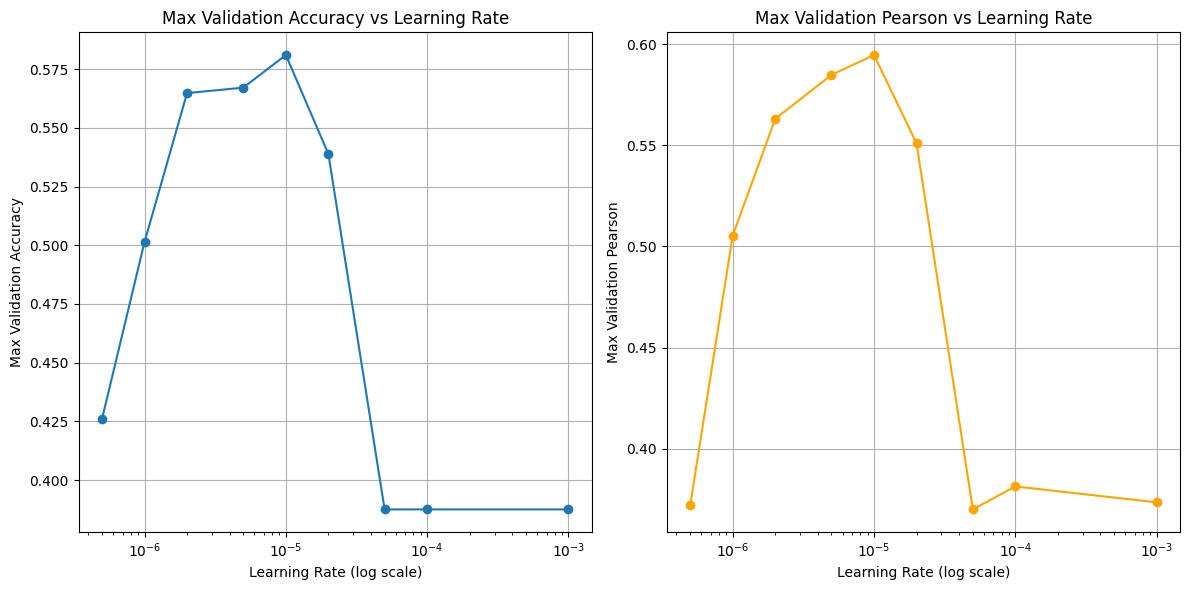

In [5]:
import matplotlib.pyplot as plt

learning_rate = [5e-7,1e-6,2e-6,5e-6,1e-5,2e-5,5e-5,1e-4,1e-3]
metrics_historys = []
for lr in learning_rate:
    metrics_historys.append(train(lr))
    
# 提取每个学习率的最大验证集准确率和皮尔逊系数
max_valid_accuracy = [max(history['valid_accuracy']) for history in metrics_historys]
max_valid_pearson = [max(history['valid_pearson']) for history in metrics_historys]

# 保存图表为文件
plt.figure(figsize=(12, 6))

# 验证集准确率
plt.subplot(1, 2, 1)
plt.plot(learning_rate, max_valid_accuracy, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Max Validation Accuracy')
plt.title('Max Validation Accuracy vs Learning Rate')
plt.grid(True)

# 验证集皮尔逊系数
plt.subplot(1, 2, 2)
plt.plot(learning_rate, max_valid_pearson, marker='o', color='orange')
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Max Validation Pearson')
plt.title('Max Validation Pearson vs Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.savefig('learning_rate_vs_metrics.png')
print("图表已保存为 'learning_rate_vs_metrics.png' 文件。")


In [6]:
# import matplotlib.pyplot as plt

# def plot_metrics(metrics_history):
#     epochs = range(1, len(metrics_history['train_accuracy']) + 1)

#     plt.figure(figsize=(14, 8))

#     # Plot accuracy
#     plt.subplot(2, 1, 1)
#     plt.plot(epochs, metrics_history['train_accuracy'], label='Train Accuracy', marker='o')
#     plt.plot(epochs, metrics_history['valid_accuracy'], label='Valid Accuracy', marker='o')
#     plt.title('Training and Validation Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Plot Pearson correlation
#     plt.subplot(2, 1, 2)
#     plt.plot(epochs, metrics_history['train_pearson'], label='Train Pearson', marker='o')
#     plt.plot(epochs, metrics_history['valid_pearson'], label='Valid Pearson', marker='o')
#     plt.title('Training and Validation Pearson Correlation')
#     plt.xlabel('Epoch')
#     plt.ylabel('Pearson Correlation')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Call the train function and plot metrics
# metrics_history = train()
# plot_metrics(metrics_history)
